# Denoising DWI data 
### with parallel computation on 8 CPU cores

In [1]:
addprocs(8)

8-element Array{Int64,1}:
 2
 3
 4
 5
 6
 7
 8
 9

### Loading juila packages to read nifti data and display images

In [2]:
push!(LOAD_PATH,"library");
using Read_NIfTI1_real
@everywhere using myFun
using PyPlot

### Loading NIFTI data

In [3]:
filename = "data/example.nii"
headerinfo = load_nii_header(filename); # see the source code in library/Read_NIfTI1_real.jl
data = load_nii_data(filename, headerinfo); # see the source code in library/Read_NIfTI1_real.jl
xdim,ydim,zdim,ddim=size(data);
println("Type of data: ", typeof(data))

Type of data: Array{Float32,4}


### Denoising data
* it may take 1 min to run this section

In [4]:
magicnumber = 64;
const xr = 5
const yr = 5
const zr = 2
datadxyz = permutedims(data,[4 1 2 3]);
datadxyz_sm = SharedArray{Float32,4}((ddim,xdim,ydim,zdim)); # this is for parallel computation
# datadxyz_sm = zeros(Float32, ddim,xdim,ydim,zdim); 
tic()
@sync @parallel for cntz = 1:zdim
    for cnty = 1:ydim
        @inbounds @fastmath @simd for cntx = 1:xdim
            tmparray = datadxyz[:,cntx,cnty,cntz];
            minx = max(cntx-xr,1);
            maxx = min(cntx+xr,xdim);
            miny = max(cnty-yr,1);
            maxy = min(cnty+yr,ydim);
            minz = max(cntz-zr,1);
            maxz = min(cntz+zr,zdim);
            Lx = maxx-minx+1;
            Ly = maxy-miny+1;
            Lz = maxz-minz+1;
            tmparray2D = datadxyz[:,minx:maxx,miny:maxy,minz:maxz];
            tmparray2Dr = reshape(tmparray2D,ddim,Lx*Ly*Lz);
            tmparray_chosen_recovered = smooth_tract_selective_PCA(tmparray,tmparray2Dr,magicnumber);            
            datadxyz_sm[:,cntx,cnty,cntz]=convert(Array{Float32},abs.(tmparray_chosen_recovered));
        end
    end
end
toc()
data_sm = permutedims(datadxyz_sm,[2,3,4,1]);


elapsed time: 26.200673665 seconds


### Displaying results

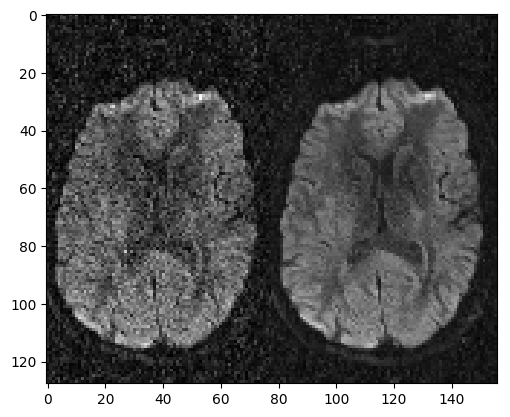

In [5]:
imshow(flipdim(hcat(data[:,:,5,12]',data_sm[:,:,5,12]'),1),cmap="gray", interpolation="none");

### Saving the results

In [6]:
newFileName = "data/images_denoised.nii"
write_nii_header(newFileName, headerinfo);
fid = open(newFileName,"a");
write(fid, data_sm);
close(fid);